## MIBI Pixel Transform
Train a pixel transform model and run it on provided data

In [48]:
import os
import errno
import random
import shutil
import zipfile
import importlib

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
from deepcell.training import train_model_sample
import matplotlib.pyplot as plt
import xarray as xr

In [49]:
# filepath constants
NPZ_DIR = "/data/npz_data"
LOG_DIR = "/data/logs"

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = keras.backend.image_data_format() == "channels_first"
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

In [50]:
# create folder for this set of experiments
experiment_folder = "20191121_Codex"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [51]:
npz_name = "Ilastik_Labels"
MODEL_NAME = npz_name + '_61_rf_512_dense_128_conv'
n_epoch = 10

In [52]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, npz_name + ".npz"))
RESIZE = False

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])

# Set up other training parameters
batch_size = 32
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (4, 964, 964, 2) & y.shape: (4, 964, 964, 1)


In [53]:
# Instantiate the model
model = bn_feature_net_2D(
    n_features=3,
    n_dense_filters=512,
    n_channels=X.shape[CHANNEL_AXIS],
    receptive_field=61,
    reg=1e-05,
    norm_method="std",
    input_shape=input_shape,
    n_conv_filters=128,
)

In [54]:
print(MODEL_NAME)

Ilastik_Labels_61_rf_512_dense_128_conv


In [ ]:
# Train the model
model = train_model_sample(
    max_class_samples=400000,
    dataset=os.path.join(NPZ_DIR, npz_name + ".npz"),
    direc_data=NPZ_DIR,
    batch_size=batch_size,
    rotation_range=180,
    balance_classes=True,
    model=model,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    transform="pixelwise",
    log_dir=LOG_DIR,
    dilation_radius=1,
    shear=False,
    lr_sched=lr_sched,
    window_size=(30, 30),
    flip=True,
    optimizer=optimizer,
    expt="sample_deepcell",
    model_name=MODEL_NAME,
    val_monitor=False,
    separate_edge_classes=False,
    save_period=1,
    class_weights=None
    #class_weights={0:3, 1:1, 2:1}
)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0}
X_train shape: (4, 964, 964, 2)
y_train shape: (4, 964, 964, 1)
Output Shape: (None, 3)
Number of Classes: 3
Training on 1 GPUs
the max_class_samples per image is 100000
analyzing image 0
the least represented class has 139347 examples
max_class_samples is less than the smalleset class, downsampling all classes
analyzing class 0
downsampling from 197441 examples per class
analyzing class 1
downsampling from 139347 examples per class
analyzing class 2
downsampling from 478621 examples per class
analyzing image 1
the least represented class has 80632 examples
analyzing class 0
downsampling from 172045 examples per class
analyzing class 1
downsampling from 80632 examples per class
analyzing class 2
downsampling from 562732 examples per class
analyzing image 2
the least represented class has 91859 examples
analyzing class 0
downsampling from 174148 examples per class
analyzing class 1
downsampling from 91859 ex

In [57]:
# assess accuracy of trained model
hist = np.load(os.path.join(MODEL_DIR, MODEL_NAME + '.npz'))
hist['loss_history'].tolist()['acc']

[0.64933558360148,
 0.6614351023285817,
 0.6665983549548509,
 0.6704476117172466,
 0.6725470377140709,
 0.6759196580081455,
 0.6978402989646388,
 0.7541483136902947,
 0.7896447481890989,
 0.808229861181505]

In [74]:
# load specific epoch of trained model to identify best version of the model
EPOCH_NAME = "_epoch_05"
weights_path = os.path.join(MODEL_DIR, MODEL_NAME + EPOCH_NAME + ".h5")

In [75]:
run_sample_model = bn_feature_net_2D(
    n_dense_filters=512,
    n_conv_filters=128,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=61,
    n_channels=3,    
    input_shape=tuple(X.shape[1:]))

run_sample_model.load_weights(weights_path)

In [76]:
# load validation data
test_npz = "Ilastik_Labels"
test_data = np.load(os.path.join(NPZ_DIR, test_npz + ".npz"))
X_test = test_data["X"]

In [85]:
#test_xr = xr.open_dataarray('/data/npz_data/TA489_Blanked.nc')
test_images = run_sample_model.predict(X_test[2:, :, :, :])
print('model output shape:', test_images.shape)

model output shape: (2, 964, 964, 3)


In [87]:
xr_output = xr.DataArray(test_images,
                         coords=[['Point3', 'Point4'], range(test_images.shape[1]), range(test_images.shape[2]), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join(MODEL_DIR, "deepcell_output1.nc"), format="NETCDF3_64BIT")

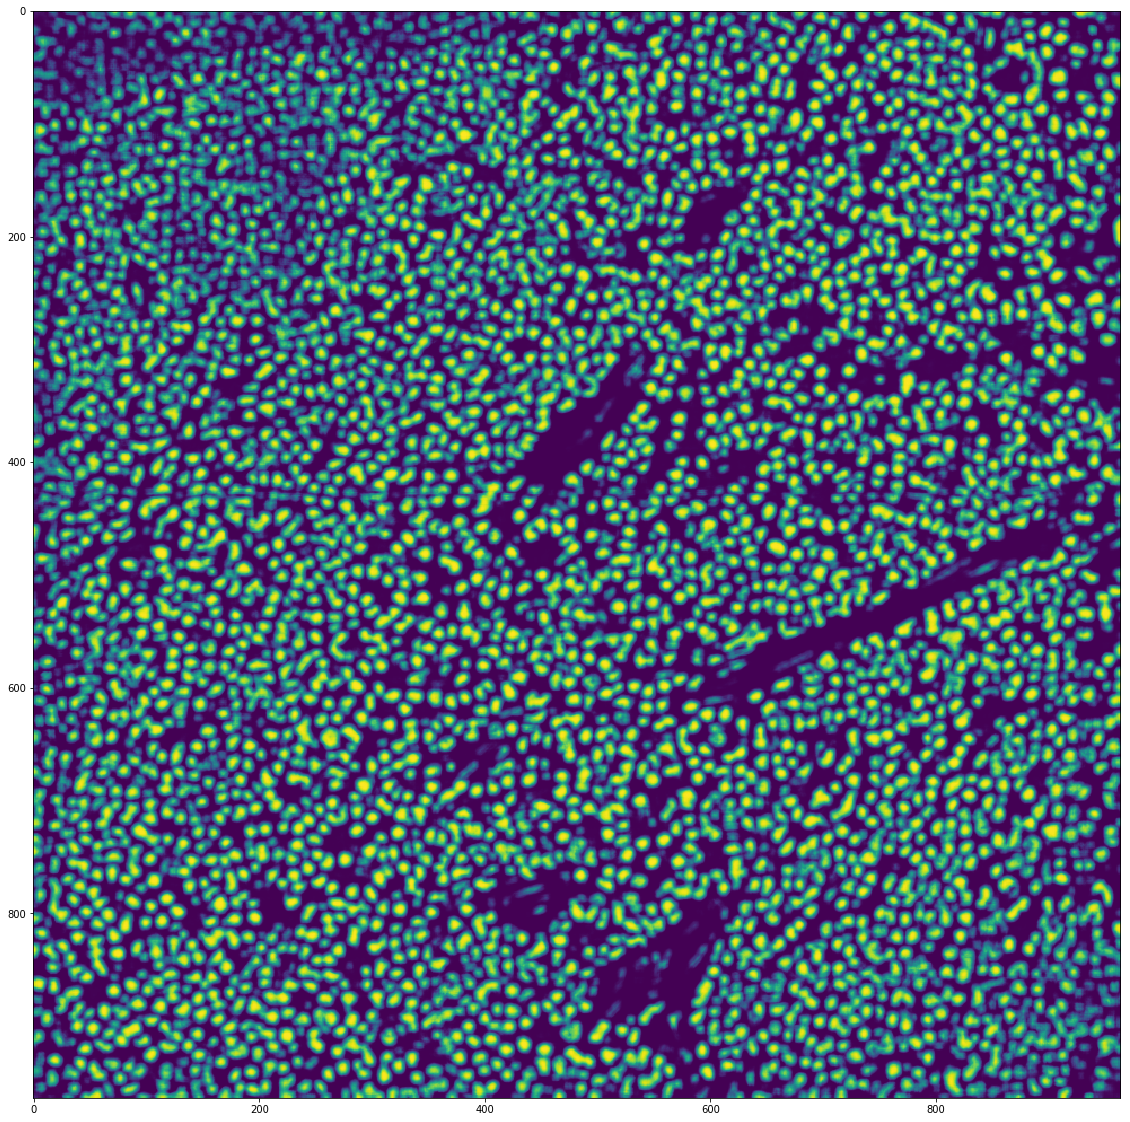

In [86]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 1])

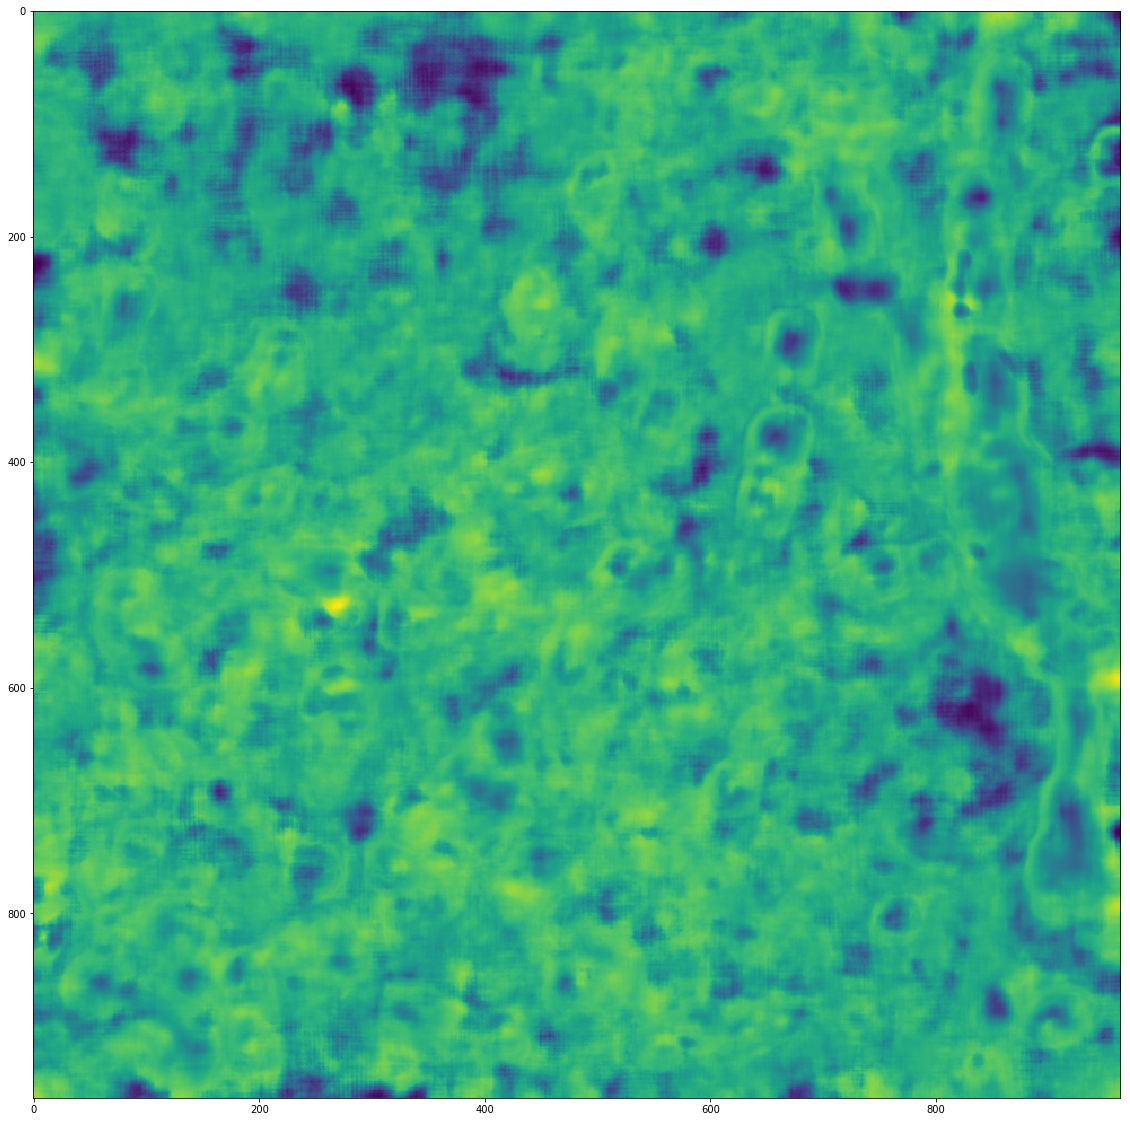

In [40]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 0])

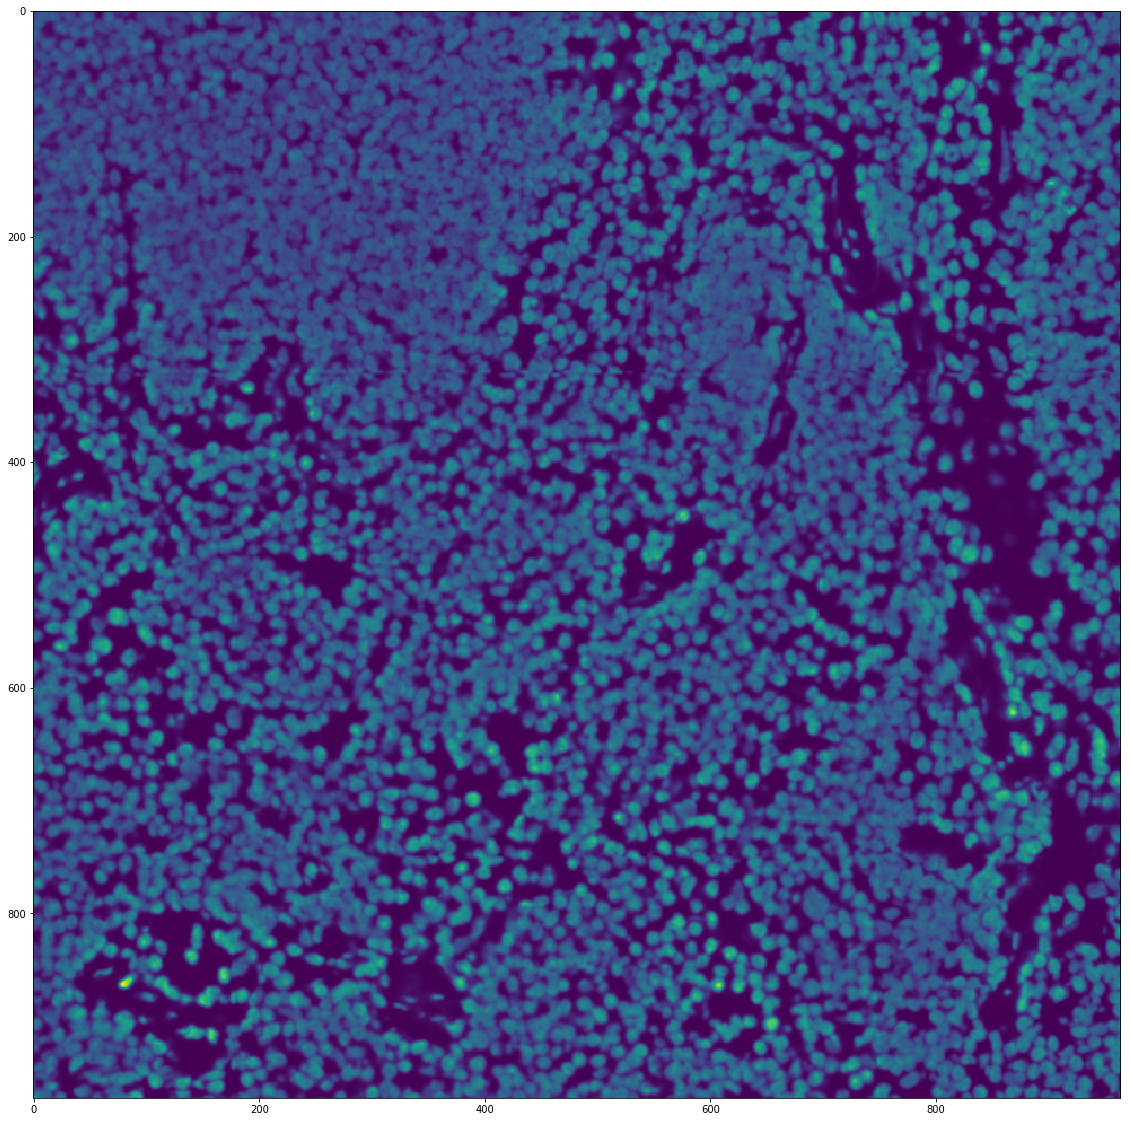

In [41]:
plt.figure(figsize = (20, 20))
plt.imshow(X_test[0, :, :, 0])